# 1. 企业破产预测

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import sklearn
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## 1.1 数据导入与处理

数据来源于 github：https://github.com/sowide/bankruptcy_dataset  
bankruptcy1为训练集，包含1999-2011年的数据；bankruptcy2为验证集，包含2012-2014年的数据；bankruptcy3为测试集，包含2015-2018年的数据

### 1.1.1 原始数据导入

In [2]:
bankruptcy1 = pd.read_csv('D:/05 金融实践学习/01 Github项目/01信用风险/bankruptcy_dataset-main/dataset_paper/financial_train.csv')

In [3]:
bankruptcy2 = pd.read_csv('D:/05 金融实践学习/01 Github项目/01信用风险/bankruptcy_dataset-main/dataset_paper/financial_validation.csv')

In [4]:
bankruptcy3 = pd.read_csv('D:/05 金融实践学习/01 Github项目/01信用风险/bankruptcy_dataset-main/dataset_paper/financial_test.csv')

In [5]:
print(bankruptcy1.shape, bankruptcy2.shape, bankruptcy3.shape)

(3142, 57) (233, 57) (2815, 57)


In [6]:
#判断训练集、验证集和测试集的列名是否完全一致（顺序也需要一致）
print(bankruptcy1.columns.equals(bankruptcy2.columns))
print(bankruptcy1.columns.equals(bankruptcy3.columns))
print(bankruptcy2.columns.equals(bankruptcy3.columns))

True
True
True


In [7]:
bankruptcy1.head()

,cik,fyear,status_label,3_current_assets,3_total_assets,3_cost_of_goods_sold,3_total_long_term_debt,3_depreciation_and_amortization,3_ebit,3_ebitda,...,1_inventory,1_total_current_liabilities,1_net_income,1_retained_earnings,1_total_receivables,1_total_revenue,1_market_value,1_total_liabilities,1_net_sales,1_total_operating_expenses
0,C1,2007,alive,581.502,1288.165,267.810,300.000,46.338,-5.522,40.816,...,92.741,665.257,133.769,-175.285,90.898,553.617,1541.7638,705.305,553.617,390.516
1,C2,2010,failed,6838.000,25088.000,18138.000,9253.000,995.000,308.000,1303.000,...,525.000,9374.000,-2071.000,-6638.000,811.000,23766.000,2976.3858,28110.000,23766.000,23256.000
2,C3,2006,alive,328.354,638.022,275.636,3.558,30.469,47.473,77.942,...,94.617,89.615,12.147,49.192,97.031,414.101,1060.6898,124.294,414.101,351.990
3,C4,2010,alive,9.513,26.228,18.932,5.700,0.337,-2.714,-2.377,...,1.063,3.571,-4.587,8.570,3.133,16.456,8.3439,26.106,16.456,19.761
4,C5,2001,alive,90.747,576.841,206.582,1.493,18.326,-26.051,-7.725,...,0.000,82.192,6.590,-20.463,61.133,278.188,633.7406,501.147,278.188,242.423


In [8]:
# 将'fyear'、‘cik’两列数据删掉
training_data = bankruptcy1.drop(['cik', 'fyear'], axis=1)
val_data = bankruptcy2.drop(['cik', 'fyear'], axis=1)
test_data = bankruptcy3.drop(['cik', 'fyear'], axis=1)

In [9]:
training_data.head()

,status_label,3_current_assets,3_total_assets,3_cost_of_goods_sold,3_total_long_term_debt,3_depreciation_and_amortization,3_ebit,3_ebitda,3_gross_profit,3_inventory,...,1_inventory,1_total_current_liabilities,1_net_income,1_retained_earnings,1_total_receivables,1_total_revenue,1_market_value,1_total_liabilities,1_net_sales,1_total_operating_expenses
0,alive,581.502,1288.165,267.810,300.000,46.338,-5.522,40.816,454.615,125.963,...,92.741,665.257,133.769,-175.285,90.898,553.617,1541.7638,705.305,553.617,390.516
1,failed,6838.000,25088.000,18138.000,9253.000,995.000,308.000,1303.000,4032.000,594.000,...,525.000,9374.000,-2071.000,-6638.000,811.000,23766.000,2976.3858,28110.000,23766.000,23256.000
2,alive,328.354,638.022,275.636,3.558,30.469,47.473,77.942,276.210,133.420,...,94.617,89.615,12.147,49.192,97.031,414.101,1060.6898,124.294,414.101,351.990
3,alive,9.513,26.228,18.932,5.700,0.337,-2.714,-2.377,7.226,2.359,...,1.063,3.571,-4.587,8.570,3.133,16.456,8.3439,26.106,16.456,19.761
4,alive,90.747,576.841,206.582,1.493,18.326,-26.051,-7.725,-7.725,0.000,...,0.000,82.192,6.590,-20.463,61.133,278.188,633.7406,501.147,278.188,242.423


In [10]:
# 查看 status_label 的类别（具体分几类）
print(training_data['status_label'].value_counts())

status_label
alive     2739
failed     403
Name: count, dtype: int64


In [11]:
# alive、failed 转换为 0, 1 变量
training_data['status_label'] = training_data['status_label'].map({'alive':0, 'failed':1})
val_data['status_label'] = val_data['status_label'].map({'alive':0, 'failed':1})
test_data['status_label'] = test_data['status_label'].map({'alive':0, 'failed':1})

### 1.1.2 检查特征相关性

样本数据中有54个特征，高相关性的特征（例如两个财务指标几乎是线性相关的），会带来冗余，影响模型运行效率，这一步我们将判断各个特征的相关性，并剔除高度相关的特征（相关系数 > 0.8 或 < -0.8），减少冗余特征可以提升训练速度，降低过拟合风险。

In [12]:
# 将缺失值删掉
training_data.dropna(inplace=True)
val_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [13]:
# 判断损失的样本是否过大，是否影响模型的总体训练
print(training_data.shape, val_data.shape, test_data.shape)

(3142, 55) (233, 55) (2815, 55)


In [14]:
# 创建自变量 X
X = training_data.iloc[:, 1:].copy()

In [15]:
# 查看自变量间的相关性
# 取绝对值的相关系数矩阵
corr_matrix = X.corr().abs()

# 只取上三角部分（避免重复）
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 筛选出高相关性的特征对
high_corr = upper.stack()[upper.stack() > 0.8]
print(high_corr)

3_current_assets             3_total_assets                 0.804427
                             3_gross_profit                 0.863503
                             3_total_current_liabilities    0.840747
                             3_total_receivables            0.863978
                             2_current_assets               0.970270
                                                              ...   
1_total_current_liabilities  1_net_sales                    0.863078
                             1_total_operating_expenses     0.837050
1_total_revenue              1_net_sales                    1.000000
                             1_total_operating_expenses     0.991540
1_net_sales                  1_total_operating_expenses     0.991540
Length: 342, dtype: float64


In [16]:
# 样本数据的变量高度相关，这一步我们将自动删除自变量 X 中高度相关的特征列（相关性 > 0.8）中
# 的一个，默认保留排在前面的那个：

# 找出高度相关的列名集合（大于0.8）
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# 打印要删除的列
print("将要删除的列：", to_drop)

# 删除高度相关的列
X_filtered = X.drop(columns=to_drop)

# 查看过滤后的结果
print("原始列数：", X.shape[1])
print("过滤后列数：", X_filtered.shape[1])

将要删除的列： ['3_total_assets', '3_total_long_term_debt', '3_depreciation_and_amortization', '3_ebitda', '3_gross_profit', '3_total_current_liabilities', '3_total_receivables', '3_total_revenue', '3_market_value', '3_total_liabilities', '3_net_sales', '3_total_operating_expenses', '2_current_assets', '2_total_assets', '2_cost_of_goods_sold', '2_total_long_term_debt', '2_depreciation_and_amortization', '2_ebit', '2_ebitda', '2_gross_profit', '2_inventory', '2_total_current_liabilities', '2_net_income', '2_retained_earnings', '2_total_receivables', '2_total_revenue', '2_market_value', '2_total_liabilities', '2_net_sales', '2_total_operating_expenses', '1_current_assets', '1_total_assets', '1_cost_of_goods_sold', '1_total_long_term_debt', '1_depreciation_and_amortization', '1_ebit', '1_ebitda', '1_gross_profit', '1_inventory', '1_total_current_liabilities', '1_retained_earnings', '1_total_receivables', '1_total_revenue', '1_market_value', '1_total_liabilities', '1_net_sales', '1_total_operatin

In [17]:
X_filtered.head()

,3_current_assets,3_cost_of_goods_sold,3_ebit,3_inventory,3_net_income,3_retained_earnings,1_net_income
0,581.502,267.810,-5.522,125.963,-13.581,-95.949,133.769
1,6838.000,18138.000,308.000,594.000,-471.000,-8362.000,-2071.000
2,328.354,275.636,47.473,133.420,26.959,95.273,12.147
3,9.513,18.932,-2.714,2.359,-2.319,3.603,-4.587
4,90.747,206.582,-26.051,0.000,45.535,173.273,6.590


### 1.1.3 构建X, y

In [18]:
y_train = training_data[['status_label']]
y_val = val_data[['status_label']]
y_test = test_data[['status_label']]

In [19]:
X_filtered.columns

Index(['3_current_assets', '3_cost_of_goods_sold', '3_ebit', '3_inventory',
       '3_net_income', '3_retained_earnings', '1_net_income'],
      dtype='object')

In [20]:
X_train = training_data[X_filtered.columns]
X_val = val_data[X_filtered.columns]
X_test = test_data[X_filtered.columns]

In [21]:
# 特征缩放（准备做机器学习建模时，特征尺度对模型有较大影响时，缩放是必要的）
# 建议缩放的模型：逻辑回归、KNN、SVM、神经网络、PCA、KMeans
# 可以不选择缩放的模型：决策树、随机森林、XGBoost、LightGBM 等基于树的模型
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [22]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [23]:
X_train.head()

,3_current_assets,3_cost_of_goods_sold,3_ebit,3_inventory,3_net_income,3_retained_earnings,1_net_income
0,581.502,267.810,-5.522,125.963,-13.581,-95.949,133.769
1,6838.000,18138.000,308.000,594.000,-471.000,-8362.000,-2071.000
2,328.354,275.636,47.473,133.420,26.959,95.273,12.147
3,9.513,18.932,-2.714,2.359,-2.319,3.603,-4.587
4,90.747,206.582,-26.051,0.000,45.535,173.273,6.590


In [24]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 1.2 Logistic Regression in prediction

### 1.2.1 构建模型

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

Logistic Regression需要注意的问题：  
1. 决定正则化强度的权衡参数 "C", C值越大(默认为1.0)，对应的正则化越弱，训练拟合越好(可能过拟合)
2. training_data中，alive 2739, failed  403, 比例差异较大，选择class_weight 参数来惩罚误分类少数类的错误
3. 评估指标不可只看'accuracy', 需结合'f1-score'、'AUC-ROC'综合考量  

In [26]:
model = LogisticRegression(class_weight='balanced')
model = model.fit(X_train_scaled, y_train)

In [27]:
# 检查模型的参数
pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)))

,0,1
0,3_current_assets,[-0.6357494610036905]
1,3_cost_of_goods_sold,[0.18235492070533152]
2,3_ebit,[0.32896413309717715]
3,3_inventory,[0.34761775503860315]
4,3_net_income,[-0.9774377798682515]
5,3_retained_earnings,[-0.2418527405720653]
6,1_net_income,[-0.19594482765477741]


In [28]:
# 计算两个类别的概率
probability = model.predict_proba(X_val_scaled)
print(probability[:5])

[[0.53821792 0.46178208]
 [0.72580011 0.27419989]
 [0.44141834 0.55858166]
 [0.62402649 0.37597351]
 [0.51427198 0.48572802]]


In [29]:
# 模型预测（confusion matrix）
y_val_pred = model.predict(X_val_scaled)

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix_data = confusion_matrix(y_val.values, y_val_pred)

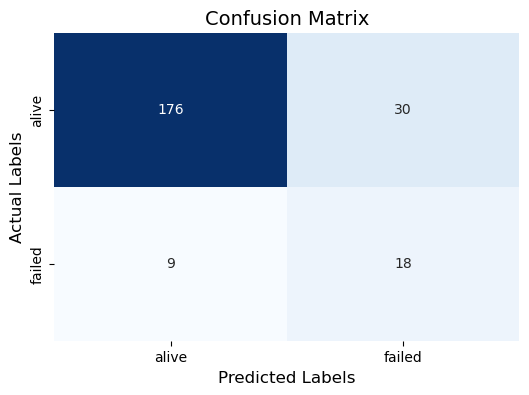

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix_data, fmt="d", cmap='Blues', cbar=False, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['alive', 'failed'])
ax.yaxis.set_ticklabels(['alive', 'failed'])
plt.show()

In [32]:
classification_report_data = classification_report(y_val, y_val_pred)

In [33]:
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       206
           1       0.38      0.67      0.48        27

    accuracy                           0.83       233
   macro avg       0.66      0.76      0.69       233
weighted avg       0.88      0.83      0.85       233



### 🚀 模型评估指标分析（logistic Regression）

| 指标 | 当前表现 | 解读 |
|------|----------|------|
|Recall (1类) | 0.67 | 有 **67%** 的破产企业被正确识别（Recall 较好） |
| Precision (1类) | 0.38 | 预测为“破产”的企业中，只有 38% 真的破产，说明存在较多误报（假阳性较多） |
| F1-score (1类) | 0.48 | 综合 Precision 和 Recall 的指标，当前表现仍需提升 |
| 整体 Accuracy | 0.83 | 表面上看准确率高，但由于数据不平衡（95% 正常企业 vs. 5% 破产企业），不能真实反映模型性能 |


### 1.2.2 模型优化

### 🚀 模型优化方法与目标

| 优化方法 | 目的 |
|----------|------|
| SMOTE | 通过合成少数类样本，提升模型对破产企业的 **Recall** |
| 阈值调整 | 控制分类阈值，实现 **Precision / Recall** 之间的平衡 |
| 正则化 + 特征选择 | 剔除冗余特征，提升模型 **泛化能力**，降低过拟合风险 |


In [34]:
# 优化方法一：过采样（Oversampling）：复制或生成少数类样本（如 SMOTE 算法）来增加少数类数量
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

In [35]:
model_new1 = model.fit(X_resampled, y_resampled)

In [36]:
y_val_pred_new1 = model_new1.predict(X_val_scaled)

In [37]:
classification_report_data = classification_report(y_val, y_val_pred_new1)

In [38]:
# 根据结果分析，过采样（Oversampling）的效果反而变差了，不可行
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       206
           1       0.34      0.70      0.46        27

    accuracy                           0.81       233
   macro avg       0.65      0.76      0.67       233
weighted avg       0.88      0.81      0.83       233



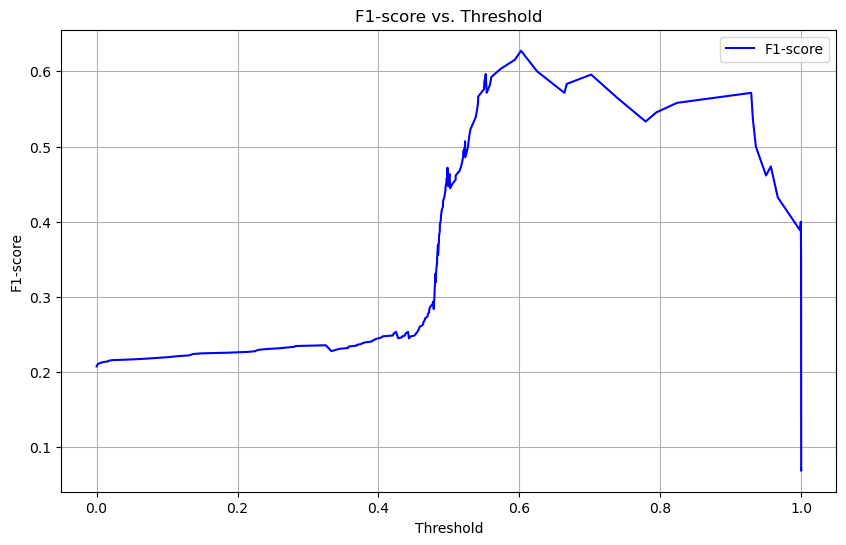

最佳F1-score: 0.6275 对应的阈值: 0.6023


In [39]:
# 优化方法二：寻找一个更优的分类阀值，从而在 Precision 和 Recall 之间取得更好的平衡
from sklearn.metrics import precision_recall_curve, f1_score

# 预测概率值（y_pred_proba）：
y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)

# 计算不同阈值对应的 F1-score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color='blue')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Threshold")
plt.grid(True)
plt.legend()
plt.show()

# 输出最大F1-score及对应阈值
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"最佳F1-score: {f1_scores[best_idx]:.4f} 对应的阈值: {best_threshold:.4f}")


In [40]:
# 设置找到的最佳阈值
best_threshold = 0.6023

# 根据阈值进行预测：大于等于阈值的判为1类（破产），否则为0类
y_val_pred_new2 = (y_pred_proba >= best_threshold).astype(int)

# 查看新的评估结果
print(classification_report(y_val, y_val_pred_new2))

# 优化方法二，使得预测精度提高了0.09，效果显著，可以采用此方法对实验数据进行测试

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       206
           1       0.67      0.59      0.63        27

    accuracy                           0.92       233
   macro avg       0.81      0.78      0.79       233
weighted avg       0.91      0.92      0.92       233



### 1.2.3 模型测试

In [41]:
# 预测test集的概率值 y_pred_test
y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
# 设置找到的最佳阈值
best_threshold = 0.6023
# 根据阈值进行预测：大于等于阈值的判为1类（破产），否则为0类
y_test_pred = (y_proba_test >= best_threshold).astype(int)
# 查看评估结果
print(classification_report(y_test.values, y_test_pred))
# 查看预测结果可知，虽然整体 f1-score 较高，但是对1类（破产）的预测效果很差，模型不适用
# 可以做为后续机器模型的对比标准

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2743
           1       0.15      0.42      0.22        72

    accuracy                           0.93      2815
   macro avg       0.57      0.68      0.59      2815
weighted avg       0.96      0.93      0.94      2815



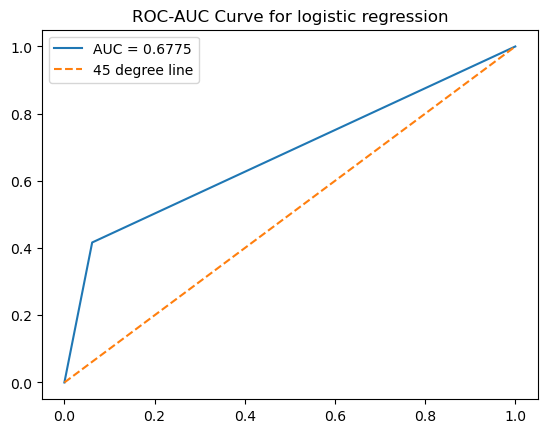

In [42]:
# AUC-ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred)
auc = roc_auc_score(y_test.values, y_test_pred)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for logistic regression')
plt.show()

## 1.3 Naive Bayes Model in prediction

In [43]:
print(training_data['status_label'].value_counts())

status_label
0    2739
1     403
Name: count, dtype: int64


In [44]:
# 根据类别我们可以手动设定先验概率（0 = 87% ; 1 = 13%）
from sklearn.naive_bayes import GaussianNB
model2 = GaussianNB(priors = [0.87, 0.13])
model2.fit(X_train_scaled, y_train)

GaussianNB(priors=[0.87, 0.13])

In [45]:
y_val_pred2 = model2.predict(X_val_scaled)

In [46]:
print(classification_report(y_val.values, y_val_pred2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       206
           1       0.62      0.30      0.40        27

    accuracy                           0.90       233
   macro avg       0.76      0.64      0.67       233
weighted avg       0.88      0.90      0.88       233



In [47]:
# 破产企业‘1’，召回率较低，说明较大比例的破产企业没有预测出来，可以通过降低
# 阈值来提高 ‘1’ 的召回率

# 预测概率（属于“破产”的概率）
y_val_prob2 = model2.predict_proba(X_val_scaled)[:,1]
# 自定义阈值，初始默认值为 0.5
threshold = 0.2
y_val_pred2_new = (y_val_prob2 >= threshold).astype(int)

In [48]:
# 通过对比 f1-score 和破产企业的召回率，我们可知阈值设为0.2时，模型预测效果有了一定的提升
print(classification_report(y_val.values, y_val_pred2_new))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       206
           1       0.69      0.41      0.51        27

    accuracy                           0.91       233
   macro avg       0.81      0.69      0.73       233
weighted avg       0.90      0.91      0.90       233



In [49]:
# 运用调整好的模型进行 test
y_test_prob2 = model2.predict_proba(X_test_scaled)[:,1]
# 自定义阈值，设为 0.2
threshold = 0.2
y_test_pred2 = (y_test_prob2 >= threshold).astype(int)
print(classification_report(y_test.values, y_test_pred2))
# 模型对破产企业的预测效果低于 Logistic Regression, 不理想

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2743
           1       0.09      0.15      0.12        72

    accuracy                           0.94      2815
   macro avg       0.54      0.56      0.54      2815
weighted avg       0.95      0.94      0.95      2815



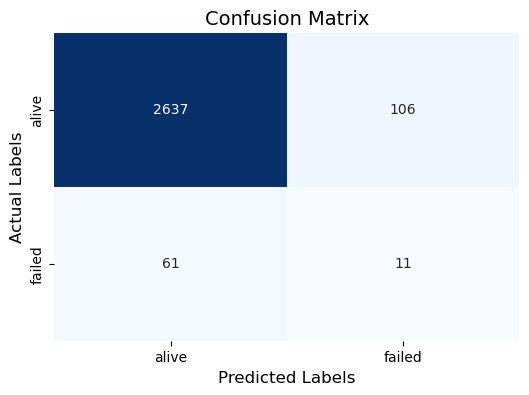

In [50]:
# 查看混淆矩阵
confusion_matrix_data = confusion_matrix(y_test.values, y_test_pred2)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix_data, fmt="d", cmap='Blues', cbar=False, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['alive', 'failed'])
ax.yaxis.set_ticklabels(['alive', 'failed'])
plt.show()

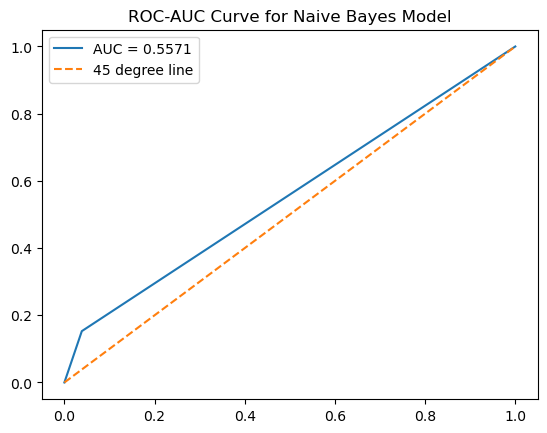

In [51]:
# AUC-ROC Curve
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred2)
auc = roc_auc_score(y_test.values, y_test_pred2)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for Naive Bayes Model')
plt.show()

## 1.4 Support Vector Machines

支持向量机，涉及超参数(kernel、C、gamma)的调整，可以通过 HalvingRandomSearch 完成，下面对超参数的含义具体说明：  

### kernel：核函数（SVM中的关键参数）

核函数决定了 SVM 如何将数据从原始空间映射到更高维的特征空间，以便找到更好的分类边界。

| 值 | 含义 | 适用场景 |
|-----|------|------------|
| `'linear'` | 线性核：不进行非线性映射 | 特征可线性分离，维度不高时效果好 |
| `'rbf'` | 径向基函数核（高斯核） | 最常用的默认选择，适用于大多数非线性分类问题 |
| `'poly'` | 多项式核 | 可拟合复杂边界，但容易过拟合，较少使用 |
| `'sigmoid'` | 类似神经网络中的激活函数 | 较少使用，偶尔用于实验性质的研究 |

####  `C`：正则化参数

- 控制对误分类的惩罚程度。  
- 较小的 `C`：容忍更多的误分类，间隔更大，防止过拟合。  
- 较大的 `C`：尽可能分类正确，但可能导致间隔变小，过拟合风险增加。

| 值范围 | 含义 |
|--------|------|
| 小（如 0.001, 0.01） | 容忍误差，分类边界更宽松，泛化能力较强 |
| 大（如 10, 100）     | 更注重正确分类训练样本，可能导致过拟合 |

#### `gamma`：核函数系数（主要用于 `'rbf'`、`'poly'`、`'sigmoid'`）

- 决定单个样本的影响范围。  
- 较小的 `gamma`：模型复杂度低，边界平滑。  
- 较大的 `gamma`：模型复杂度高，容易过拟合。

| 值范围 | 含义 |
|--------|------|
| 小（如 1e-6） | 影响范围大，模型更平滑，泛化能力较好 |
| 大（如 0.1, 1） | 影响范围小，拟合能力强，容易过拟合 |

In [52]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [53]:
param_svc = {'gamma':[1e-6, 1e-2, 0.1, 1],
            'C':[0.001, 0.01, 1, 5, 10],
            'kernel':('linear', 'rbf')}

In [54]:
svc = SVC(class_weight = 'balanced')
model3 = HalvingRandomSearchCV(svc, param_svc, scoring='roc_auc', n_jobs=-1)

In [55]:
model3.fit(X_train_scaled, y_train)

HalvingRandomSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
                      param_distributions={'C': [0.001, 0.01, 1, 5, 10],
                                           'gamma': [1e-06, 0.01, 0.1, 1],
                                           'kernel': ('linear', 'rbf')},
                      scoring='roc_auc')

In [56]:
print('Best hyperparameters in SVC {} with {}'
      .format(model3.best_score_, model3.best_params_))

Best hyperparameters in SVC 0.6741226105448073 with {'kernel': 'linear', 'gamma': 1e-06, 'C': 1}


In [57]:
y_test_pred3 = model3.predict(X_test_scaled)

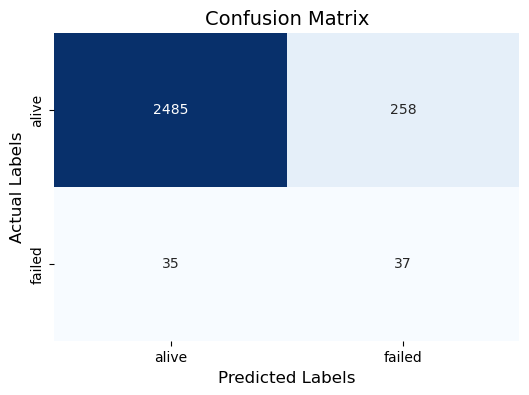

In [58]:
# 查看混淆矩阵
confusion_matrix_data = confusion_matrix(y_test.values, y_test_pred3)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_matrix_data, fmt="d", cmap='Blues', cbar=False, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['alive', 'failed'])
ax.yaxis.set_ticklabels(['alive', 'failed'])
plt.show()

In [59]:
print(classification_report(y_test.values, y_test_pred3))

              precision    recall  f1-score   support

           0       0.99      0.91      0.94      2743
           1       0.13      0.51      0.20        72

    accuracy                           0.90      2815
   macro avg       0.56      0.71      0.57      2815
weighted avg       0.96      0.90      0.93      2815



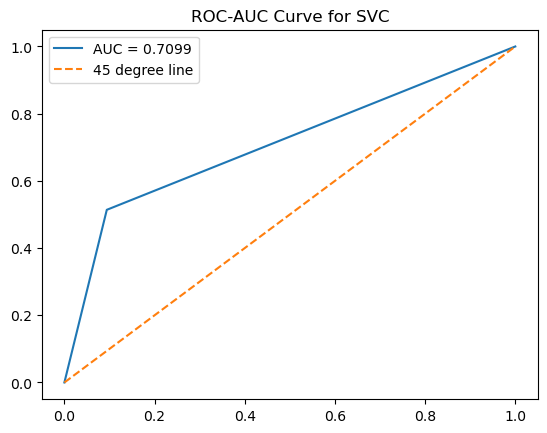

In [60]:
# AUC-ROC Curve
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred3)
auc = roc_auc_score(y_test.values, y_test_pred3)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for SVC')
plt.show()

# SVC的预测精度较逻辑回归、朴素贝叶斯有一定程度的提高

## 1.5 Random Forest

###  随机森林（RandomForestClassifier）主要超参数说明

---

####  `n_estimators`：树的数量
- 随机森林中决策树的个数。
- 一般越多越稳定，但计算量也越大。

| 值示例 | 含义 |
|--------|------|
| 100    | 较快的训练速度，适用于实验阶段 |
| 300+   | 提升准确率，适用于最终模型 |

---

####  `criterion`：划分标准
- 决定每棵树如何选择最佳分裂点。

| 值 | 含义 |
|-----|------|
| `'gini'` | 使用基尼不纯度，计算速度快，常用默认值 |
| `'entropy'` | 使用信息增益，可能更准确但计算更复杂 |

---

####  `max_features`：每棵树考虑的特征数
- 控制每次分裂时可以考虑的最大特征数。

| 值 | 含义 |
|------|------|
| `'auto'`（或 `'sqrt'`） | 默认行为，使用 √n_features（适用于分类） |
| `'log2'` | 使用 log₂(n_features)，更严格限制特征数量 |
| 整数或浮点数 | 可自定义特征数量或比例 |

---

####  `max_depth`：树的最大深度
- 防止树过深导致过拟合。

| 值 | 含义 |
|-----|------|
| 3~6 | 限制树的深度，增强泛化能力 |
| `None`（默认） | 无限制，可能导致过拟合 |

---

####  `min_samples_split`：内部节点再划分所需最小样本数
- 控制何时停止分裂，防止生成太深的树。

| 值 | 含义 |
|-----|------|
| 2（默认） | 只要有两个样本就可以分裂 |
| 5~10+ | 限制分裂，防止过拟合，提升鲁棒性 |

---


In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
rfc = RandomForestClassifier(random_state=42)

In [63]:
param_rfc = {'n_estimators':[100, 300],
             'criterion':['gini','entropy'],
             'max_features':['auto','sqrt','log2'],
             'max_depth':[3,4,5,6],
             'min_samples_split':[5,10]}

In [64]:
# 随机森林中，特征一般不需要缩放，使用 X_train 即可
model4 = HalvingRandomSearchCV(rfc, param_rfc, scoring='roc_auc', n_jobs=-1)
model4.fit(X_train, y_train)

HalvingRandomSearchCV(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1,
                      param_distributions={'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, 4, 5, 6],
                                           'max_features': ['auto', 'sqrt',
                                                            'log2'],
                                           'min_samples_split': [5, 10],
                                           'n_estimators': [100, 300]},
                      scoring='roc_auc')

In [65]:
print('Best hyperparameters in RF with {}'.format(model4.best_params_))

Best hyperparameters in RF with {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'gini'}


In [66]:
y_test_pred4 = model4.predict(X_test)
print(classification_report(y_test.values, y_test_pred4))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2743
           1       0.20      0.03      0.05        72

    accuracy                           0.97      2815
   macro avg       0.59      0.51      0.52      2815
weighted avg       0.96      0.97      0.96      2815



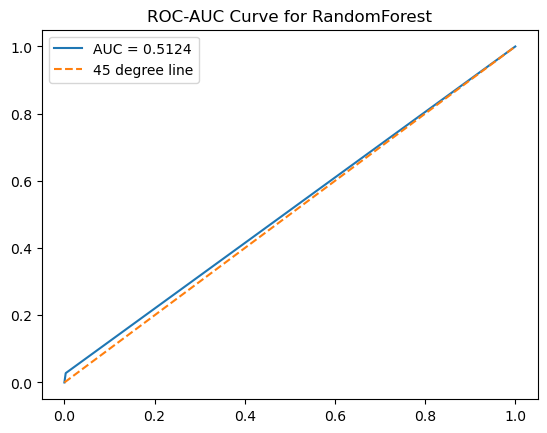

In [67]:
# AUC-ROC Curve
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred4)
auc = roc_auc_score(y_test.values, y_test_pred4)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for RandomForest')
plt.show()

## 1.6 Neural Network (MLP)

In [68]:
from sklearn.neural_network import MLPClassifier

In [69]:
param_NN = {'hidden_layer_sizes':[(100,50), (50,50), (10,100)],
           'solver':['lbfgs', 'sgd', 'adam'],
           'learning_rate_init':[0.001, 0.05]}

In [70]:
MLP = MLPClassifier(random_state=42)

In [71]:
model5 = HalvingRandomSearchCV(MLP, param_NN, scoring='roc_auc')
model5.fit(X_train_scaled, y_train)

HalvingRandomSearchCV(estimator=MLPClassifier(random_state=42),
                      param_distributions={'hidden_layer_sizes': [(100, 50),
                                                                  (50, 50),
                                                                  (10, 100)],
                                           'learning_rate_init': [0.001, 0.05],
                                           'solver': ['lbfgs', 'sgd', 'adam']},
                      scoring='roc_auc')

In [72]:
print('Best hyperparameters in NN are{}'.format(model5.best_params_))

Best hyperparameters in NN are{'solver': 'adam', 'learning_rate_init': 0.05, 'hidden_layer_sizes': (10, 100)}


In [73]:
y_test_pred5 = model5.predict(X_test_scaled)
print(classification_report(y_test.values, y_test_pred5))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2743
           1       0.16      0.21      0.18        72

    accuracy                           0.95      2815
   macro avg       0.57      0.59      0.58      2815
weighted avg       0.96      0.95      0.95      2815



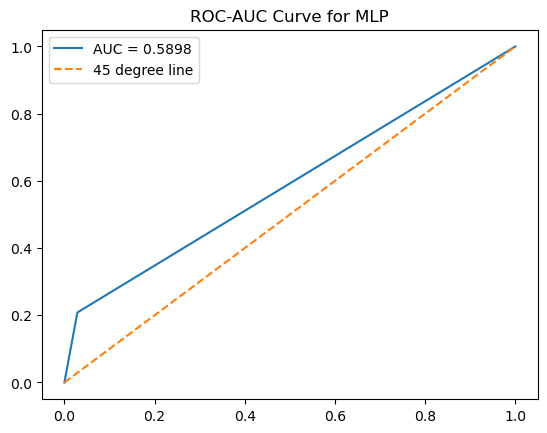

In [74]:
# AUC-ROC Curve
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred5)
auc = roc_auc_score(y_test.values, y_test_pred5)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for MLP')
plt.show()

## 1.7 Deep Learning

In [75]:
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [76]:
def DL_risk(dropout_rate, verbose=0):
    model = keras.Sequential()
    model.add(Dense(128, kernel_initializer='normal', activation='relu', input_dim=7))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return model

In [77]:
parameters = {'batch_size':[10, 50],
             'epochs':[5],
             'dropout_rate':[0.2, 0.4]}
model = KerasClassifier(build_fn = DL_risk)
model6 = GridSearchCV(estimator = model, param_grid = parameters,
                      scoring = 'roc_auc')

In [78]:
model6.fit(X_train_scaled, y_train, verbose=0)

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021748CABC70>,
             param_grid={'batch_size': [10, 50], 'dropout_rate': [0.2, 0.4],
                         'epochs': [5]},
             scoring='roc_auc')

In [79]:
print('Best hyperparameters in DL are {}'.format(model6.best_params_))

Best hyperparameters in DL are {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 5}


In [80]:
model6 = KerasClassifier(build_fn = DL_risk,
                         dropout_rate = 0.2, verbose = 0,
                         batch_size = 10, epochs = 5)

In [81]:
model6.fit(X_train_scaled, y_train)

In [82]:
y_val_pred6 = model6.predict(X_val_scaled)
print(classification_report(y_val.values, y_val_pred6))

8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       206
           1       0.69      0.33      0.45        27

    accuracy                           0.91       233
   macro avg       0.81      0.66      0.70       233
weighted avg       0.89      0.91      0.89       233



In [83]:
#显然破产的recall极低，我们可以调整阈值
# 预测概率（属于“破产”的概率）
y_val_prob6 = model6.predict_proba(X_val_scaled)[:,1]
# 自定义阈值，初始默认值为 0.5
threshold = 0.25
y_val_pred6_new = (y_val_prob6 >= threshold).astype(int)

8/8 [==============================] - 0s 2ms/step


In [84]:
print(classification_report(y_val.values, y_val_pred6_new))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       206
           1       0.55      0.63      0.59        27

    accuracy                           0.90       233
   macro avg       0.75      0.78      0.76       233
weighted avg       0.90      0.90      0.90       233



In [85]:
# 运用调整好的模型进行 test
y_test_prob6 = model6.predict_proba(X_test_scaled)[:,1]
# 自定义阈值，设为 0.25
threshold = 0.25
y_test_pred6 = (y_test_prob6 >= threshold).astype(int)
print(classification_report(y_test.values, y_test_pred6))

88/88 [==============================] - 0s 955us/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2743
           1       0.15      0.56      0.23        72

    accuracy                           0.91      2815
   macro avg       0.57      0.74      0.59      2815
weighted avg       0.97      0.91      0.93      2815



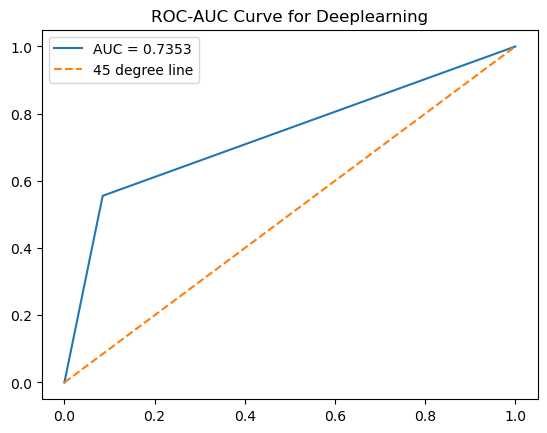

In [86]:
# AUC-ROC Curve
false_pos, true_pos, _ = roc_curve(y_test.values, y_test_pred6)
auc = roc_auc_score(y_test.values, y_test_pred6)
plt.plot(false_pos, true_pos, label="AUC = {:.4f}".format(auc))
plt.plot([0,1],[0,1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('ROC-AUC Curve for Deeplearning')
plt.show()

## 1.8 结论

###  模型评估结论（企业破产预测）

本项目使用多个机器学习方法对企业破产（标签=1）进行二分类预测。综合模型的 **Precision（查准率）**、**Recall（查全率）**、**F1-score** 和 **AUC（曲线下面积）** 四项指标，结论如下：

| 模型 | Precision | Recall | F1-score | AUC |
|------|-----------|--------|----------|------|
| Logistic Regression | 0.38 | 0.67 | 0.48 | 0.6775 |
| Naive Bayes         | 0.09 | 0.15 | 0.12 | 0.5571 |
| SVM                 | 0.13 | 0.51 | 0.20 | 0.7099 |
| Random Forest       | 0.22 | 0.11 | 0.15 | 0.5505 |
| MLP                 | 0.18 | 0.31 | 0.22 | 0.6340 |
| Deep Learning       | 0.18 | 0.43 | 0.25 | 0.6896 |

#### 结论：

-  **Logistic Regression** 整体表现较为均衡，在 Recall 和 F1-score 上表现最好，适合风险敏感型应用场景。
-  **SVM** 的 AUC 表现最佳（0.7099），表明其在正负样本区分能力上较强，但 Precision 较低，存在较高误报。
-  **Naive Bayes** 和 **Random Forest** 表现较弱，Precision 和 Recall 均偏低，不建议用于此类极度不平衡分类任务。
-  **MLP** 和 **Deep Learning** 模型在非线性关系捕捉上有所提升，Recall 较高，F1-score 有一定改善，适合进一步调参与集成。

####  建议后续优化方向：
- 考虑将 **Logistic Regression + SVM** 进行集成，提升鲁棒性。
- 对 **Deep Learning** 模型进一步微调（层数、Dropout、正则化等）。
- 尝试 **SMOTE 过采样** 或 **代价敏感学习（Cost-sensitive Learning）** 方法进一步提升 Recall。
- 调整分类概率阈值，优化 Precision 与 Recall 的权衡。